# <u> Sentiment Analysis and Feature selection on a Large Movie Review Dataset </u>


## <u> Data Set Description </u>

#### <u> The source of the dataset is: http://ai.stanford.edu/~amaas/data/sentiment/
<li><b></b> As the dataset is not a csv file, but a collection of several text files contained in sub directories. The function is written below to read file from the path to our local directory. 
<li><b></b>Both train and test dataset contains 25000 reviews respectively. 

## <u> The notebook covers the following topics:
<li><b></b> Perform sentiment analysis using self implemented Naive Bayes and compared the accuracy with builtin multinomial naive bayes classification model. 
<li><b></b> Improving the accuracy using Logistic Regression classification model.
<li><b></b> Perform dimensionaility reduction by doing feature selection using mutual info classifier and acheive the same accuracy as above while using reduced set of features. 
    

In [1]:
import pandas as pd
import io
import re 
import random
from collections import Counter
import math
from math import log 
from decimal import Decimal
import operator
from __future__ import division

In [2]:
# Function to split the string on space
def dummy_tokenizer(s):
    return s.split()

In [3]:
# Function to extract the vocabulary(unique words) in the text
def extract_vocab(data):
    vocab = set()
    for ex in data:
        tokens = dummy_tokenizer(ex)
        for token in tokens:
            if token: vocab.add(token)
    return vocab

In [4]:
# Function written to retreive the prior and conditional probability of the training documents
def training(train_x, train_y, vocab):
    prior = {}
    cond_prob = {}
    total_docs = len(train_x)
    classes = set(train_y)
    for t in vocab:
        cond_prob[t] = {c:0 for c in classes}
        
    for cls in classes:
        cls_idx_train = [i for i in range(len(train_y)) if train_y[i] == cls]
        Nc = len(cls_idx_train)
        prior[cls] = Nc/total_docs
        cls_x = dummy_tokenizer(' '.join([train_x[i] for i in cls_idx_train])) 
        term_dist_cls = Counter(cls_x)
        normalizer = len(cls_x) + len(vocab)
        for t in vocab: 
            if t in term_dist_cls.keys():
                cond_prob[t][cls] = (term_dist_cls[t]+1)/normalizer 
            else:
                cond_prob[t][cls] = 1/normalizer 
        
                
    return prior, cond_prob 

In [5]:
# Using the learned prior, conditional probability, vocabulary and the classes(neg, pos), function is written to get the score of the
# the test documents
def testing(classes, vocab, prior, cond_prob, test_x) :
    test_pred = []
    for ex in test_x:
        tokens = dummy_tokenizer(ex) 
        score = {cls: 1.0*math.log(prior[cls]) for cls in classes}
        for cls in classes: 
            for t in tokens:
                if t not in vocab:
                    continue
                score[cls] += log(cond_prob[t][cls]) 
        test_pred.append(max(score.items(), key = operator.itemgetter(1))[0])  
        
    return test_pred 

In [6]:
# Function to calculate accuracy
def cal_accuracy(test_pred, test_y):
    correct = 0
    for i in range(len(test_pred)):
        if test_pred[i] == test_y[i]:
            correct +=1 
    
    return  correct*100/len(test_pred)

In [7]:
# Function to calculate evaluation parameters such as: "Precision, Recall, F1"
def cal_evaluation(test_pred, test_y):
    TP, FP, TN, FN = [0]*4 
    count_DES, count_IDF = 0,0
    count = Counter(test_y)
    #print(count)
    for i in range(len(test_pred)):
        if test_pred[i] == test_y[i]:
            if test_pred[i] == "pos":
                TP +=1
            else:
                TN +=1 
        else: 
            if test_pred[i] == "neg":
                FP +=1
            else:
                FN +=1    
    
    pr = TP/(TP+FP) 
    re = TP/(TP+FN)
    F1 = (2*pr*re)/(pr+re)
    pr_class2 = TN/(TN+FN) 
    re_class2 = TN/(TN+FP) 
    F1_class2 = (2*pr_class2*re_class2)/(pr_class2 + re_class2)
    wt_pr = (count['pos'] * pr + count['neg'] * pr_class2)/len(test_y)
    wt_re = (count['pos'] * re + count['neg'] * re_class2)/len(test_y)
    wt_F1 = (count['pos'] * F1 + count['neg'] * F1_class2)/len(test_y)
    return wt_pr, wt_re, wt_F1

In [8]:
# This function reads the data from the local directory
import os, sys

def text_process(s):
    s = s.strip().lower()   
    s = re.sub(r'\bhttp.+?( |$)', ' ', s)
    s = re.sub(r'[^a-zA-Z0-9 ]', ' ', s)
    s = re.sub(r'[0-9]', 'd', s) 
    s = re.sub(r'\s+', ' ', s) 
    return s
    
# Open a file
def read_data(path):    
    dirs = os.listdir(path)
    X_train, y_train, X_test, y_test = [], [], [], [] 
    for d in dirs:
        if d != 'train' and d != 'test':
            continue
        sub_dirs = os.listdir(path + d)
        for sd in sub_dirs:
            if sd != 'pos' and sd != 'neg':
                continue
            files = os.listdir( path + d + '/' + sd)
            for x in files:
                if '_' not in x:
                    continue
                with open(path + d + '/' + sd + '/' + x) as f:
                    if d == 'train':
                        X_train.append(text_process(f.read().replace('\n', '')))
                        y_train.append(sd)
                    else:
                        X_test.append(text_process(f.read().replace('\n', '')))
                        y_test.append(sd)
                                   
    return  X_train, y_train, X_test, y_test



In [9]:
if __name__ ==  "__main__":   
    path = "C:/Users/biyani/Documents/Machine_Learning/Yelp_Project/aclImdb/"
    X_train, y_train, X_test, y_test = read_data(path)
    print("Read the data!")
    

Read the data!


In [87]:
len(X_test)

25000

In [94]:
vocab = extract_vocab(X_train)
prior, cond_prob = training(X_train,y_train,vocab)
classes = set(y_train)
test_pred = testing(classes, vocab, prior, cond_prob, X_test)

print("Accuracy is as follows", cal_accuracy(test_pred, y_test))
print ("weighted Precision, Recall, F1 is as follows: ", cal_evaluation(test_pred, y_test))

('Accuracy is as follows', 80.872)
('weighted Precision, Recall, F1 is as follows: ', (0.80872, 0.8142758826964673, 0.8078708679323536))


#### As we can see above, using self-implemented Naive Bayes, we get an accuracy of 80.872%. 

#### Now, let's use sklearn's builtin multinomial Naive Bayes model.

In [10]:
from collections import Counter
Counter(y_train)
# len(X_train)

Counter({'neg': 12500, 'pos': 12500})

In [11]:
def dumb_tokenizer(t):
    return t.split()

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
def feature_extraction(data, is_tfidf=False):    
    count_vect = CountVectorizer(tokenizer=dumb_tokenizer, stop_words='english', ngram_range=(1,1), max_df=0.9, min_df=3)
    X_data_counts = count_vect.fit_transform(data)
    if is_tfidf == True:
        tfidf_vectorizer = TfidfVectorizer(tokenizer=dumb_tokenizer, stop_words='english', ngram_range=(1,1), max_df=0.9, min_df=3)
#         tfidf_transformer = TfidfTransformer() 
        X_data_tfidf = tfidf_vectorizer.fit_transform(data)
        return X_data_tfidf, tfidf_vectorizer
    return X_data_counts, count_vect

In [13]:
# X_train_tf, tf_vectorizer = feature_extraction(X_train)
X_train_tfidf, tfidf_vectorizer = feature_extraction(X_train, is_tfidf=True)

In [14]:
X_train_tfidf.shape

(25000, 198013)

In [15]:
# vectorized and tfidf of test data
# X_test_tf = tf_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf.shape

(25000, 198013)

In [91]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import confusion_matrix, classification_report, f1_score


def classify(X, y, X_test, y_test, classifier):
    classifier.fit(X, y)
    predicted = classifier.predict(X_test)
    
     
    
#     print('Classification report with MNB using tf as term encoding\n')
#     print(classification_report(y_test, predicted, target_names=['neg', 'pos'] , digits = 4))
#     print(confusion_matrix(y_test, predicted))
    
    return f1_score(y_test, predicted, average='weighted')
    


In [85]:
classify(X_train_tfidf, y_train, X_test_tfidf, y_test, MultinomialNB())

Classification report with MNB using tf as term encoding

             precision    recall  f1-score   support

        neg     0.8334    0.8857    0.8587     12500
        pos     0.8780    0.8230    0.8496     12500

avg / total     0.8557    0.8543    0.8542     25000

[[11071  1429]
 [ 2213 10287]]


0.85417659002579016

In [88]:
classify(X_train_tfidf, y_train, X_test_tfidf, y_test, lr())

Classification report with MNB using tf as term encoding

             precision    recall  f1-score   support

        neg     0.8799    0.8766    0.8783     12500
        pos     0.8771    0.8804    0.8787     12500

avg / total     0.8785    0.8785    0.8785     25000

[[10958  1542]
 [ 1495 11005]]


0.87851957063957065

In [24]:
feature_names = tfidf_vectorizer.get_feature_names()

###################################### Feature Selection ########################################################

###### Feature selection, is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection is done because data contains many features that are either redundant or irrelevant, and can thus be removed without incurring much loss of information. Thus, doing feature selection results in, simplication of models, shorter training times, reducing overfitting, and avoids the curse of dimensionality. 


In [17]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest
mi = mutual_info_classif(X_train_tfidf, y_train)
print(mi.shape)

(198013L,)


In [19]:
print(mi.shape)

(198013L,)


In [18]:
mi[:3]

array([ 0.00013863,  0.00016636,  0.00011091])

In [20]:
tmp = sorted(mi)

In [21]:
import numpy as np

In [22]:
tmp[:10]

[8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05,
 8.3178461764182063e-05]

In [25]:
len(feature_names)

198013

In [26]:
feature_to_mi = {i:mi[i] for i in range(len(feature_names))}

In [27]:
import operator
feature_idx_sorted_by_mi = sorted(feature_to_mi, key=feature_to_mi.get, reverse=True)

In [28]:
feature_idx_sorted_by_mi[0:5]

[145713, 114457, 170759, 16618, 16988]

In [92]:
k_values = [200000]
f1_scores, num_of_features = [], []

for k in range(1000, 40000, 1000):
#     print("Selecting top", k, "features")
    indices = feature_idx_sorted_by_mi[:k]
#     print("Transforming train!")
    X_new_train = X_train_tfidf[:, indices]
#     print("Transforming test!")
    X_new_test = X_test_tfidf[:, indices]    
    score = classify(X_new_train, y_train, X_new_test, y_test, lr())
    
    f1_scores.append(score)
    num_of_features.append(k)
    
    

    

In [93]:
f1_scores

[0.8501079200567806,
 0.86257005984306923,
 0.86725742824070995,
 0.87070236090576048,
 0.87198439725351229,
 0.87302584065438438,
 0.87334753658702446,
 0.87422821488188218,
 0.87483108376748864,
 0.87527201740911409,
 0.87547347261829822,
 0.87623427707297186,
 0.87579432409870495,
 0.8759951715495915,
 0.87655578986114657,
 0.87679602514408161,
 0.87719667939821089,
 0.87711697688101853,
 0.87731683398914462,
 0.87759648339592944,
 0.87759658758870729,
 0.87767708695321955,
 0.87783736988743855,
 0.87759736472022354,
 0.87807763958310248,
 0.8781574664550944,
 0.8781574664550944,
 0.87827695692392294,
 0.87835715044326357,
 0.87867743281447841,
 0.87875760987601792,
 0.87863835647207855,
 0.87859852977963515,
 0.87871842819082924,
 0.87891853365500994,
 0.87887856669740694,
 0.87899885213471074,
 0.87891885137579173,
 0.87871869520721035]

Text(0.5,1,'F1 score as a function of number of features')

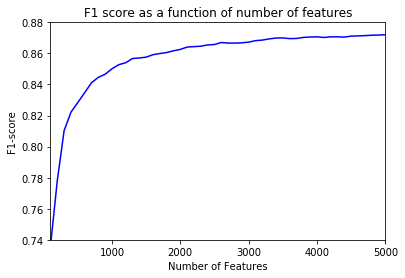

In [69]:
import matplotlib.pyplot as plt
axes = plt.gca()
axes.set_xlim([100, 6000])
axes.set_ylim([0.74, 0.88])
plt.plot(num_of_features,f1_scores, color='blue' )
classify(X_train_tfidf, y_train, X_test_tfidf, y_test, MultinomialNB())
plt.xlabel("Number of Features")
plt.title("F1 score as a function of number of features")
